# Oscilação de membranas

In [6]:
import numpy as np
import scipy
from scipy import linalg
from scipy.sparse import diags, linalg
import matplotlib.pylab as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
import time

In [7]:
# Função para plotar os curvas de nível constante de temperatura
def PlotaMembrane(N1,N2,L1,L2,W):
    x = np.linspace(0, L1, N1)
    y = np.linspace(0, L2, N2)
    X,Y=np.meshgrid(x,y)
    Z = np.copy(W)
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.set(xlabel='x', ylabel='y', title='Deslocamento vertical')
    im = ax.contourf(X, Y, Z, 20)
    im2 = ax.contour(X, Y, Z, 20, linewidths=0.25, colors='k')
    fig.colorbar(im, ax=ax)
    plt.show()
    
def PlotaSurface(N1,N2,L1,L2,W):
    x = np.linspace(0, L1, N1)
    y = np.linspace(0, L2, N2)
    X,Y=np.meshgrid(x,y)
    Z = np.copy(W)
    ax = plt.axes(projection ='3d')
    ax.plot_surface(X, Y, Z,cmap='viridis', edgecolor='none')
    ax.set(xlabel='x', ylabel='y', title='Deslocamento vertical')
    ax.set_zlim(-1.01, 1.01)
    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False)
    

In [8]:
def ij2n (i, j, N):
    return i + j*N

def BuildMatrizesEigen(N1, N2, sigma, rho, e, delta):
    nunk = N1*N2

    # Stiffness matrix K: Build it as a sparse matrix 
    d1 = 4.0*np.ones(nunk)
    d2 = -np.ones(nunk-1)
    d3 = -np.ones(nunk-N1)
    K = (sigma/delta**2)*scipy.sparse.diags([d3, d2, d1, d2, d3], [-N1, -1, 0, 1, N1], format='csr')

    # Force the eigenvalues associated to boundary points 
    # to be a big number as compared to fundamental modes
    big_number = 10000
    Iden = big_number*scipy.sparse.identity(nunk, format='csr')

    # Lados verticais
    for k in range(0,N2):
        Ic = ij2n(0,k,N1) # Left
        K[Ic,:], K[:,Ic] = Iden[Ic,:], Iden[:,Ic]

        Ic = ij2n(N1-1,k,N1) # Right
        K[Ic,:], K[:,Ic] = Iden[Ic,:], Iden[:,Ic]
        
    # Lados horizontais
    for k in range(0,N1):
        Ic = ij2n(k,0,N1) # Bottom
        K[Ic,:], K[:,Ic] = Iden[Ic,:], Iden[:,Ic]

        Ic = ij2n(k,N2-1,N1) # Top
        K[Ic,:], K[:,Ic] = Iden[Ic,:], Iden[:,Ic]

    # Mass matrix: Simple case, multiple of identity
    M = rho*e*scipy.sparse.identity(nunk, format='csr')
    
    return K, M    

## Resolver um problema

In [9]:
# Tamanho da grade
N1 = 41
N2 = 21
L1 = 1.0
L2 = 0.5
# Distancia entre pontos: Cuidado que L1/(N1-1) seja igual a L2/(N2-1)
delta = L1 / (N1-1) 

# Tensão da membrana
sigma = 1.0
rho = 1
e = 1

# Aplicar restrições nas bordas
K, M = BuildMatrizesEigen(N1, N2, sigma, rho, e, delta)
#print(K.todense(), "\n\n", M.todense())
#plt.spy(K, markersize=0.75)

# Calcular modos de oscilação

# Método tipo Francis: Todos os autovalores e autovetores (não trabalha com esparsas)
#Lam, Q = linalg.eigh(K.todense(), M.todense())

# Método tipo potencias: Apenas os modos fundamentais (trabalha com esparsas!)
Lam, Q = scipy.sparse.linalg.eigsh(K, k=20, M=M, which='SM')

omegas = np.sqrt(Lam)
print(omegas)

[ 7.01867809  8.87663338 11.30546615 12.90285549 14.00058777 14.00058777
 15.6536067  16.8220928  17.69853937 18.93788939 19.7021936  19.7021936
 20.00511544 20.90921752 22.48106471 22.48106471 22.60417625 24.33854183
 24.92007524 25.06333222]


## Plotar os modos

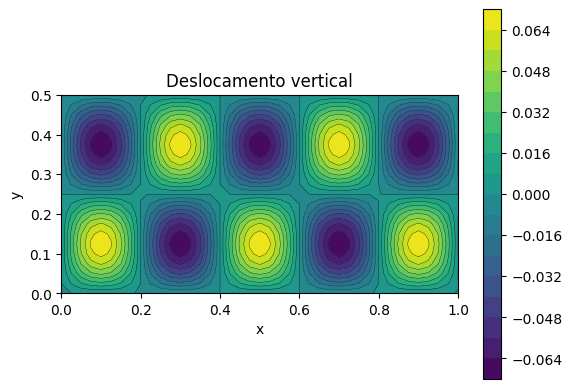

In [10]:
# Plotar Escolher um modo
k = 12
mode = Q[:,k]# + Q[:,1] + Q[:,2] + + Q[:,5] + Q[:,12]
#mode[np.where(np.abs(mode) < 1e-10)] = 0.0
#print('\nFrequencias:', omegas,'\n')

Wplot = mode.reshape(N2,N1)
PlotaMembrane(N1,N2,L1,L2,Wplot)

In [11]:
print(np.sqrt(1/500))


0.044721359549995794


In [12]:
# Make a movie (it is a bit slow)
if(True):
    x = np.linspace(0, L1, N1)
    y = np.linspace(0, L2, N2)
    X,Y=np.meshgrid(x,y)
    Z = np.copy(Wplot)
    
    fps = 4 # frame per sec
    frn = 20 # frame number of the animation
    zarray = np.zeros((N1, N2, frn))
    for i in range(frn):
        zarray[:,:,i] = 10*np.sin(2*np.pi*i/frn)*Wplot # Multiplico x10 para exagerar o deslocamento

    def update_plot(frame_number, zarray, plot):
        plot[0].remove()
        plot[0] = ax.plot_surface(X, Y, zarray[:,:,frame_number], cmap=cm.coolwarm,linewidth=0, antialiased=False)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set(xlabel='x', ylabel='y', title='Deslocamento vertical')
    plot = [ax.plot_surface(X, Y, zarray[:,:,0], color='0.75', rstride=1, cstride=1)]
    ax.set_zlim(-1.1, 1.1)

    ani = animation.FuncAnimation(fig, update_plot, frn, fargs=(zarray, plot), interval=1000/fps)

    fn = 'membanim'
    ani.save(fn+'.mp4',writer='ffmpeg',fps=fps)
    print('\n ... Movie generated\n')

ValueError: could not broadcast input array from shape (21,41) into shape (41,21)